In [1]:
import pandas as pd
import numpy as np
import argparse
import time
import math
import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Crippen
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import GetPeriodicTable
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors
from padelpy import padeldescriptor, from_smiles

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import metrics
from sklearn.svm import SVR

import xgboost as xgb

import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch.nn import Linear, Sequential, BatchNorm1d #, ReLU
from torch.nn.functional import relu
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import ARMAConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_add_pool

# Read Data from Files

In [2]:
total_padel_summation = pd.read_csv('../step1-generating and merging descriptors/total_padel_descriptors_summation.csv')
Z_total = pd.read_csv('../step1-generating and merging descriptors/total_property.csv')

In [3]:
total_padel_summation=np.array(total_padel_summation)

In [4]:
Z_total = np.array(Z_total)
Z_total = Z_total.ravel()

In [5]:
Z_total.shape

(979,)

# Applying Borutapy on Padel descriptors with AM

## Using xGBoost as base model  

In [6]:
# Define the XGBoost regressor
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV

xg_reg_padel_summation = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                 max_depth = 3, alpha = 1, n_estimators = 100)

xg_reg_padel_summation.fit(total_padel_summation,Z_total)

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [7]:
from boruta import BorutaPy
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# define Boruta feature selection method
feat_selector_padel_summation = BorutaPy(xg_reg_padel_summation, n_estimators='auto', verbose=2, random_state=1,max_iter=250)

# find all relevant features
feat_selector_padel_summation.fit(np.array(total_padel_summation), np.array(Z_total))

# check selected features
feat_selector_padel_summation.support_

# check ranking of features
feat_selector_padel_summation.ranking_



Iteration: 	1 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	2 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	3 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	4 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	5 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	6 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	7 / 250
Confirmed: 	0
Tentative: 	1875
Rejected: 	0
Iteration: 	8 / 250
Confirmed: 	0
Tentative: 	422
Rejected: 	1453
Iteration: 	9 / 250
Confirmed: 	0
Tentative: 	422
Rejected: 	1453
Iteration: 	10 / 250
Confirmed: 	15
Tentative: 	407
Rejected: 	1453
Iteration: 	11 / 250
Confirmed: 	15
Tentative: 	407
Rejected: 	1453
Iteration: 	12 / 250
Confirmed: 	15
Tentative: 	318
Rejected: 	1542
Iteration: 	13 / 250
Confirmed: 	24
Tentative: 	309
Rejected: 	1542
Iteration: 	14 / 250
Confirmed: 	24
Tentative: 	309
Rejected: 	1542
Iteration: 	15 / 250
Confirmed: 	24
Tentative: 	309
Rejected: 	1542
Iteration: 	

array([ 199,  148,  297, ..., 1292, 1292,  432])

In [8]:
# call transform() on X to filter it down to selected features
X_filtered_xG_padel_summation = feat_selector_padel_summation.transform(np.array(total_padel_summation))

In [9]:
total_padel_summation_df = pd.DataFrame(total_padel_summation)

# Access the column names
names_selected_padel_summation_descriptors = total_padel_summation_df.columns[feat_selector_padel_summation.support_]
selected_padel_summation_descriptors = pd.DataFrame(X_filtered_xG_padel_summation)
selected_padel_summation_descriptors.columns = names_selected_padel_summation_descriptors
selected_padel_summation_descriptors.to_csv('xG_baruta_total_padel_summation.csv',index=False)

In [10]:
xg_reg_padel_summation.fit(X_filtered_xG_padel_summation, Z_total)

# compute predictions
predictions = xg_reg_padel_summation.predict(X_filtered_xG_padel_summation)

# create a dataframe with real predictions and values
df_padel_summation = pd.DataFrame({'pred': predictions, 'observed': Z_total})

# let's print the dataframe
print("\n------Predizioni e valori reali------\n")
print(df_padel_summation)

# compute RMSE
mse_padel_summation = ((df_padel_summation['pred'] - df_padel_summation['observed']) ** 2).mean()
rmse_padel_summation = np.sqrt(mse_padel_summation)
print("\n------RMSE------\n", round(rmse_padel_summation, 3))


------Predizioni e valori reali------

         pred  observed
0    2.595818  2.857332
1    1.001980  0.991226
2    0.949924  0.991226
3    0.833738  0.903090
4    0.714905  0.732394
..        ...       ...
974  1.686504  1.851000
975  1.324762  1.342000
976  1.308295  1.322000
977  1.306156  1.301000
978  1.586405  1.623000

[979 rows x 2 columns]

------RMSE------
 0.127


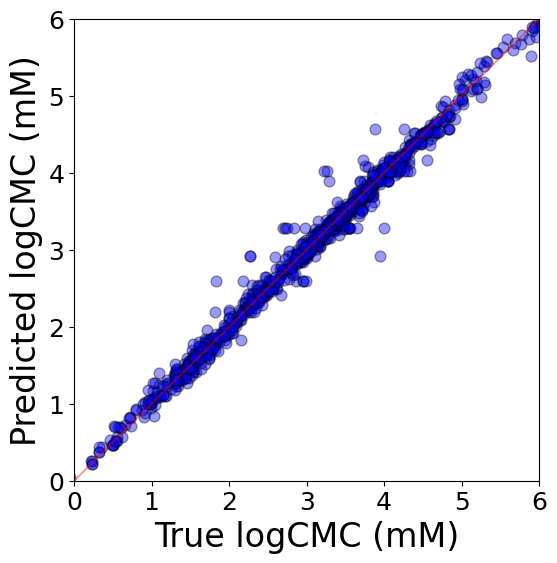

In [11]:
label_fs = 24
ticks_fs = 18
marker_s = 60
ap = 0.4

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(df_padel_summation['observed'], df_padel_summation['pred'], s=marker_s, alpha=ap, color='Blue', edgecolor='black')
plt.plot([0,6], [0,6], alpha=ap, color='red')
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel('True logCMC (mM)', fontsize=label_fs)
plt.ylabel('Predicted logCMC (mM)', fontsize=label_fs)
plt.xticks(fontsize=ticks_fs)
plt.yticks(fontsize=ticks_fs)
plt.show()

# END of File